*from [here](https://github.com/zylo117/Yet-Another-EfficientDet-Pytorch)*

# efficientdet_test.py
- 배치 사이즈 조절 기능 추가
- 탐지된 객체의 좌표와 클래스 저장

```python
# Author: Zylo117

"""
Simple Inference Script of EfficientDet-Pytorch
"""

# RuntimeError: cuDNN error: CUDNN_STATUS_ALLOC_FAILED
# PYTORCH_CUDA_ALLOC_CONF

# solution
# model.to(device)
# batch size 1000 to 32

# RuntimeError: CUDA out of memory. Tried to allocate 1.17 GiB (GPU 0; 8.00 GiB total capacity; 3.44 GiB already allocated; 1.14 GiB free; 4.86 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# solution

# batch size 32 -> 2
# input data -> cpu()
# del input data
# gc.collect()
# torch.cuda.empty_cache()

import time
import torch
from torch.backends import cudnn
from matplotlib import colors

from backbone import EfficientDetBackbone
import cv2
import numpy as np
import os
import pandas as pd
import tqdm
import csv 
import gc

from efficientdet.utils import BBoxTransform, ClipBoxes
from utils.utils import preprocess, invert_affine, postprocess, STANDARD_COLORS, standard_to_bgr, get_index_label, plot_one_box


compound_coef = 6
force_input_size = None 
device = 'cuda' if torch.cuda.is_available() else 'cpu'


ROOT_PATH = "C:\github\petfinder\EfficientDet"
os.chdir(ROOT_PATH)
img_path = os.listdir("dataset/train")

anchor_ratios = [(1.0, 1.0), (1.4, 0.7), (0.7, 1.4)]
anchor_scales = [2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)]

threshold = 0.2
iou_threshold = 0.2

use_cuda = True
use_float16 = False

cudnn.fastest = True
cudnn.benchmark = True

obj_list = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
            'fire hydrant', '', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep',
            'cow', 'elephant', 'bear', 'zebra', 'giraffe', '', 'backpack', 'umbrella', '', '', 'handbag', 'tie',
            'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
            'skateboard', 'surfboard', 'tennis racket', 'bottle', '', 'wine glass', 'cup', 'fork', 'knife', 'spoon',
            'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut',
            'cake', 'chair', 'couch', 'potted plant', 'bed', '', 'dining table', '', '', 'toilet', '', 'tv',
            'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
            'refrigerator', '', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
            'toothbrush']


color_list = standard_to_bgr(STANDARD_COLORS)
input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536, 1536]
input_size = input_sizes[compound_coef] if force_input_size is None else force_input_size

BATCH_SIZE = 1

model = EfficientDetBackbone(compound_coef=compound_coef, num_classes=len(obj_list),
                            ratios=anchor_ratios, scales=anchor_scales)
model.load_state_dict(torch.load(f'weights/efficientdet-d{compound_coef}.pth', map_location=device))
model.requires_grad_(False)
model.eval()

def display(preds, imshow=True, imwrite=False): #imgs

    col_class, col_points, col_scores = [], [], []
    for i in range(len(preds)):
        # if len(preds[i]['rois']) == 0:
        #     continue
        

        row_class,row_points,row_scores = [], [],[]

        for j in range(len(preds[i]['rois'])):
            x1, y1, x2, y2 = preds[i]['rois'][j].astype(np.int64)
            obj = obj_list[preds[i]['class_ids'][j]]
            score = float(preds[i]['scores'][j])


            if obj in ["cat","dog"]:
                row_class.append(obj)
                row_points.append((x1, y1, x2, y2))
                row_scores.append(score)
        
        
        col_class.append(row_class)
        col_points.append(row_points)
        col_scores.append(row_scores)

    return col_points,col_class,col_scores


model = model.to(device)
# if use_cuda:
#     model = model.cuda()
# if use_float16:
#     model = model.half()

train_csv = pd.read_csv("dataset/train.csv")

for START in tqdm.tqdm(range(0,9912,BATCH_SIZE)):
    
    gc.collect()
    torch.cuda.empty_cache()

    END = START+BATCH_SIZE
    if END > 9913:
        END = 9913
    
        
    framed_imgs, framed_metas, img_ids = preprocess(img_path,START,END,"dataset/train/", max_size=input_size)

    if use_cuda:
        x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
    else:
        x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

    x = x.to(torch.float32 if not use_float16 else torch.float16).permute(0, 3, 1, 2)

    with torch.no_grad():
        features, regression, classification, anchors = model(x)
 

        regressBoxes = BBoxTransform()
        clipBoxes = ClipBoxes()

        out = postprocess(x.cpu().numpy(),
                        anchors, regression, classification,
                        regressBoxes, clipBoxes,
                        threshold, iou_threshold)

    del x
    

    out = invert_affine(framed_metas, out)

    series_points, series_class,series_scores = display(out, imshow=False, imwrite=False) #ori_imgse

    save_file = (img_ids,series_class,series_points,series_scores)


    # with open("dataset/objmeta.csv",'w') as file:
    #     file.write(img_ids)
    #     file.write(series_points)
    #     file.write(series_class)

    # import pickle
    # with open('data_dict.pkl','wb') as f:
    #     pickle.dump(save_file,f)







    for i,id in enumerate(img_ids):
        id = id.split(".")[0]
        
        train_csv.loc[train_csv["Id"] == id]["box"] = [np.nan if not series_points[i] else series_points[i]]
        train_csv.loc[train_csv["Id"] == id]["classes"] = [np.nan if not series_class[i] else series_class[i]]
        train_csv.loc[train_csv["Id"] == id]["scores"] = [np.nan if not series_scores[i] else series_scores[i]]
    
train_csv.to_csv("train_obj.csv",index=False)

```

## 발생한 에러

## 메모리 관련 에러  

- RuntimeError: cuDNN error: CUDNN_STATUS_ALLOC_FAILED PYTORCH_CUDA_ALLOC_CONF

- RuntimeError: CUDA out of memory. Tried to allocate 1.17 GiB (GPU 0; 8.00 GiB total capacity; 3.44 GiB already allocated; 1.14 GiB free; 4.86 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

> 원인 분석

메모리(RAM) 용량 부족

- 시도한 해결책
1. 하드웨어(HDD)의 일정 부분을 가상 램으로 할당 (min 12GB ~ max 480GB)
    - 최대 217 GB(램 48GB + HDD 169GB)
    - 실패 : 컴퓨터가 중간에 멈춤

2. 메모리 최적화 (코드 리팩토링)

원본
```python
def preprocess(*image_path, max_size=512, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    ori_imgs = [cv2.imread(img_path) for img_path in image_path]
    normalized_imgs = [(img[..., ::-1] / 255 - mean) / std for img in ori_imgs]
    imgs_meta = [aspectaware_resize_padding(img, max_size, max_size,
                                            means=None) for img in normalized_imgs]
    framed_imgs = [img_meta[0] for img_meta in imgs_meta]
    framed_metas = [img_meta[1:] for img_meta in imgs_meta]

    return ori_imgs, framed_imgs, framed_metas


```

수정

### A. 변수 할당 최소화

```python
imgs_meta = [aspectaware_resize_padding(cv2.imread(img_path)[..., ::-1] / 255 - mean) / std, max_size, max_size,
                                            means=None) for img_path in image_path]

```

### B. 안쓰는 메모리 정리

```python
import gc
gc.collect()
torch.cuda.empty_cache()

... 중략 ...

# 사용한 변수 삭제
del x
```

### C. 전처리 모듈화

- padding
- image resize

- 기존 preprocess() 에서 padding, image resize 기능을 모듈화하여, 모델 사용 전 일괄 전처리



### D. 하드웨어로 가상 메모리(RAM) 할당

하드웨어(HDD)의 남는 용량을 가상 램으로 할당
- min 12 GB ~ max 480 GB


### E. 경량화 모델로 변경

- Efficientdet d6 -> Efficientdet d0로 변경




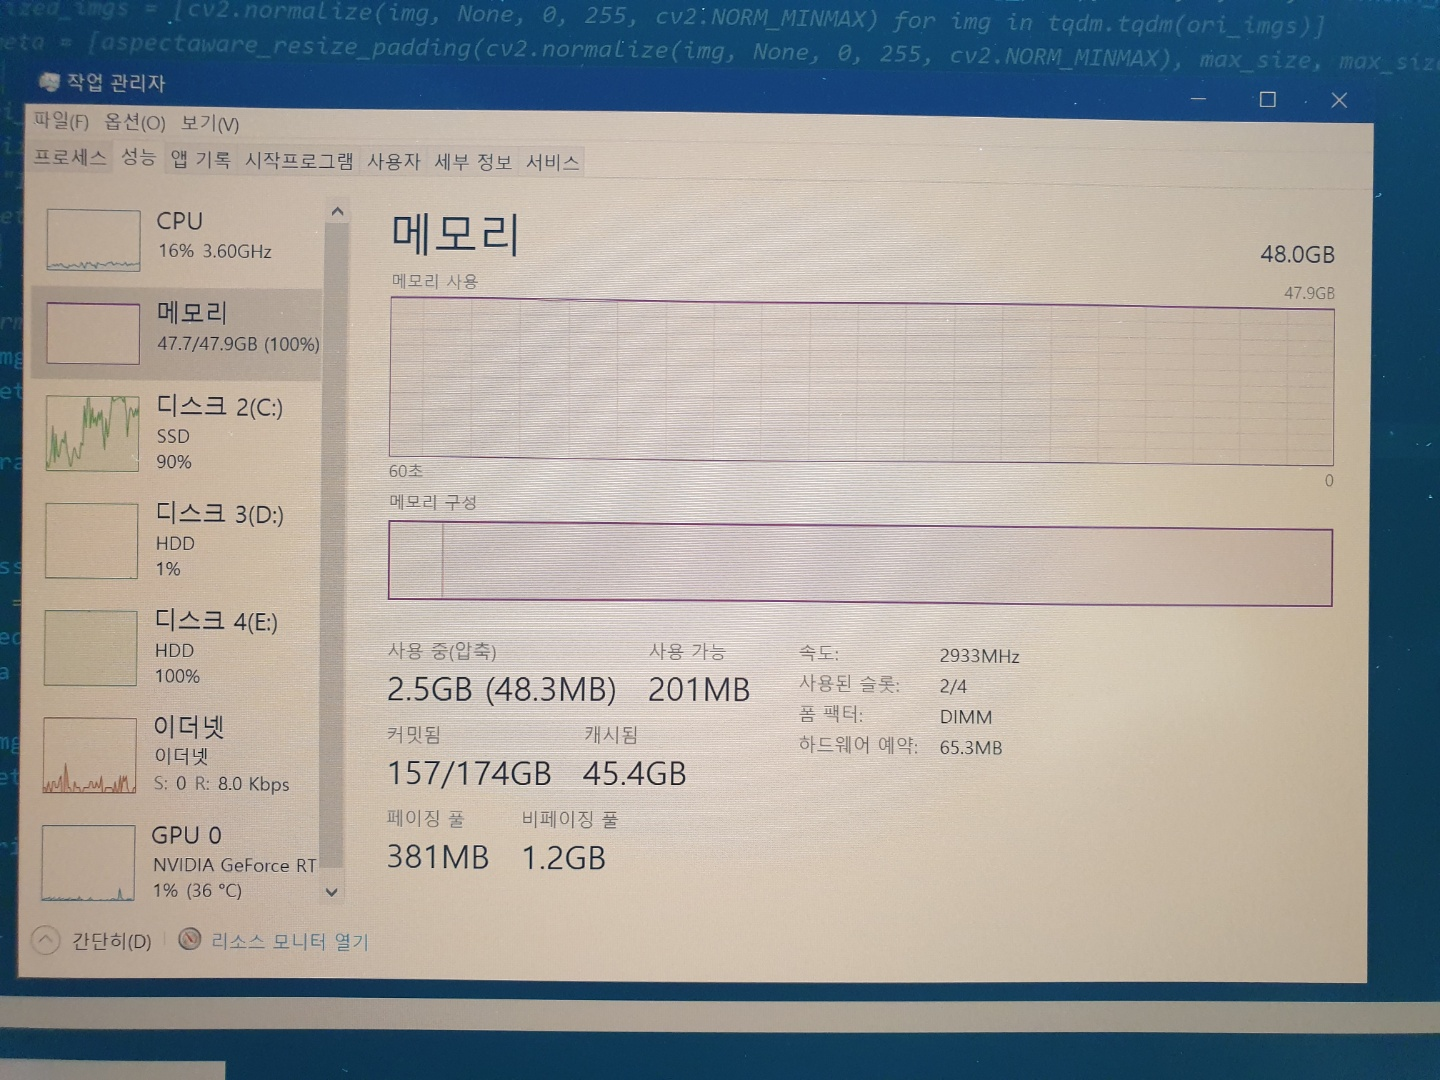

## 성능 이슈

- csv로 저장한 객체 좌표, 클래스을 검사

1. 탐지한 객체의 좌표, 클래스이 실제 이미지와 다름
2. 아무것도 탐지하지 못한 이미지의 비율 : 85%

> 원인 분석

1. 모델과 코드의 구조를 제대로 파악하지 못함
    - 코드를 수정한 사항이 의도대로 동작하지 않음
2. 모델을 사전 훈련된 가중치가 우리 데이터 셋에 맞지 않음
    - 라벨이 없기 때문에 전이학습을 하지 못함



# 추후 대안 : 직접 데이터셋을 구해서 훈련시키기

- [ ] Cat/Dog 데이터 수집
- [ ] CNN 모델 만들기
- [ ] 사전 훈련된 resnet50
